# Hand Coordinate Calculations from Depth Camera

## 0. Import Library

In [250]:
import rerun as rr
import rerun.blueprint as rrb
from utils import frame_to_bgr_image
from pyorbbecsdk import *
import numpy as np
import cv2 
import os
import glob
import albumentations as A
import copy
import matplotlib.pyplot as plt
from einops import rearrange

## 1. Utility Function

In [253]:
def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            print(f"Depth frame width: {width}")
            height = depth_frame.get_height()
            print(f"Depth frame height: {height}")
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            print(f"Color frame width: {width}")
            height = color_frame.get_height()
            print(f"Color frame height: {height}")

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def visualize_frames_rerun(data_root: str, recording_label: str):
    """
    Visualize a specified recording across all gesture classes using Rerun.
    Automatically rearranges RGB frames from (C, H, W) to (H, W, C); leaves depth frames (H, W) intact.

    Args:
        data_root: Root directory containing class subfolders.
        recording_label: Prefix for recording files (e.g. 'recording_1').
    """
    # Define the gesture classes (folder names)
    classes = ["Hand_Open", "Intrinsic_Plan", "Straight_Fist", "Hand_Close", "Hook_Hand"]
    segmented_data = {}

    # Load and preprocess each class's recording
    for cls in classes:
        folder_path = os.path.join(data_root, cls)
        file_path = os.path.join(folder_path, f"{recording_label}_{cls}.npy")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"Expected file not found: {file_path}")

        data = np.load(file_path)
        # data shape: (T, C, H, W) for RGB or (T, H, W) for depth
        frames = []
        for t in range(data.shape[0]):
            frame = data[t]
            if frame.ndim == 3:
                # RGB: rearrange channels
                frame = rearrange(frame, 'c h w -> h w c')
            elif frame.ndim == 2:
                # Depth: keep as is
                pass
            else:
                raise ValueError(f"Unrecognized frame shape {frame.shape} in {file_path}")
            frames.append(frame)
        segmented_data[cls] = frames

    # Initialize Rerun recording
    stream = rr.new_recording("spawn", spawn=True)

    # Build grid blueprint dynamically
    views = [rrb.Spatial2DView(origin=f"/{cls.lower()}_image") for cls in classes]
    blueprint = rrb.Blueprint(rrb.Grid(*views))

    # Stream frames over time for each class
    num_frames = len(segmented_data[classes[0]])
    for idx in range(num_frames):
        stream.set_time_sequence("frame", idx)
        for cls in classes:
            key = f"{cls.lower()}_image"
            frame = segmented_data[cls][idx]
            stream.log(key, rr.Image(frame))

    # Finalize layout
    stream.send_blueprint(blueprint)

## 2. Data Preprocessing

### `.bag` file to `.npy`

In [ ]:
import os
import glob
import copy
import numpy as np

def find_bag_files(directory):
    """Find all .bag files in the specified directory.
    
    Args:
        directory (str): Directory path to search for .bag files
        
    Returns:
        list: List of paths to .bag files
    """
    bag_files = glob.glob(os.path.join(directory, '*.bag'))
    print(f"Found {len(bag_files)} bag files")
    return bag_files

def process_bag_files(bag_files):
    """Process multiple bag files and store their frames.
    
    Args:
        bag_files (list): List of paths to .bag files
        
    Returns:
        dict: Dictionary with recording data
    """
    processed_data = {}
    
    for idx, bag_file in enumerate(bag_files):
        print(f"Processing bag file: {bag_file}")
        
        # Process the frames in the bag file
        depth_images, color_images = process_frames(bag_file)
        
        # Store the lists in the dictionary under the key `recording_{idx}`
        processed_data[f"recording_{idx}"] = {
            "depth_images": depth_images,
            "color_images": color_images
        }
    
    return processed_data

def create_transform_pipeline():
    """Create an image transformation pipeline.
    
    Returns:
        A.Compose: Albumentations transformation pipeline
    """
    return A.Compose([
        A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
    ])

def apply_transform(image, pipeline):
    """Apply transformation pipeline to an image.
    
    Args:
        image (np.ndarray): Input image
        pipeline (A.Compose): Transformation pipeline
        
    Returns:
        np.ndarray: Transformed image
    """
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

def save_as_npy(clip, output_path, modality_type):
    """Save frames as .npy file.
    
    Args:
        clip (np.ndarray): Stack of frames
        output_path (str): Output file path
        modality_type (str): Type of modality ('rgb' or 'depth')
    """
    if modality_type == "rgb":
        # Reorder to (T, C, H, W)
        clip_npy = clip.transpose(0, 3, 1, 2)
    else:
        # Depth: keep as (T, H, W)
        clip_npy = clip
    
    np.save(output_path, clip_npy)
    print(f"Saved {output_path}")

def save_as_mp4(clip, output_path, modality_type, fps=10):
    """Save frames as .mp4 video file.

    Args:
        clip (np.ndarray): Stack of frames
        output_path (str): Output file path
        modality_type (str): Type of modality ('rgb' or 'depth')
        fps (int): Frames per second
    """
    # Get height and width from the first frame
    if clip.ndim == 4:  # RGB
        height, width, channels = clip[0].shape
    else:  # Depth
        height, width = clip[0].shape

    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=(modality_type == "rgb"))

    for frame in clip:
        if modality_type == "depth":
            # Normalize depth to 0-255 range for visualization
            depth_norm = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            # Convert to 3-channel for VideoWriter (even though isColor=False, this prevents errors)
            depth_norm = cv2.cvtColor(depth_norm, cv2.COLOR_GRAY2BGR)
            out.write(depth_norm)
        else:
            # Convert to BGR for OpenCV
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)

    out.release()
    print(f"Saved {output_path}")   

def process_recordings(processed_data, base_save_dir, save_format='npy'):
    """Process recordings and save transformed frames as specified format.
    
    Args:
        processed_data (dict): Dictionary with recording data
        base_save_dir (str): Base directory to save outputs
        save_format (str): Format to save ('npy' or 'mp4')
    """
    # Define modality mapping
    modalities = {
        "color_images": "rgb",
        "depth_images": "depth",
    }
    
    # Create transformation pipeline
    pipeline = create_transform_pipeline()
    
    for recording_name, recording in processed_data.items():
        for modality, frames in recording.items():
            # Create output directory
            out_dir = os.path.join(base_save_dir, modalities[modality])
            os.makedirs(out_dir, exist_ok=True)
            
            # Transform each frame
            transformed_frames = []
            for frame in frames:
                tf = apply_transform(frame, pipeline)
                transformed_frames.append(tf)
            
            # Stack frames
            clip = np.stack(transformed_frames, axis=0)  # shape = (T, H, W, C) or (T, H, W)
            
            # Save based on chosen format
            if save_format.lower() == 'npy':
                output_path = os.path.join(out_dir, f"{recording_name}.npy")
                save_as_npy(clip, output_path, modalities[modality])
            elif save_format.lower() == 'mp4':
                output_path = os.path.join(out_dir, f"{recording_name}.mp4")
                save_as_mp4(clip, output_path, modalities[modality])
            else:
                raise ValueError(f"Unsupported save format: {save_format}. Choose 'npy' or 'mp4'")

def main():
    """Main function to orchestrate the processing pipeline."""
    # Define directories
    bags_dir = r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402'
    base_save_dir = os.path.join(bags_dir, 'video')
    
    # Find bag files
    bag_files = find_bag_files(bags_dir)
    
    # Process bag files
    processed_data = process_bag_files(bag_files)
    
    # Process recordings and save results
    process_recordings(processed_data, base_save_dir,save_format='mp4')

if __name__ == "__main__":
    main()

**Visualize Processed Data**

In [ ]:
import os
import glob
import numpy as np
from einops import rearrange
import rerun as rr
import rerun.blueprint as rrb


def load_npy_data(base_dir, modality):
    """Load .npy files for a specific modality.
    
    Args:
        base_dir (str): Base directory
        modality (str): Modality type ('rgb' or 'depth')
        
    Returns:
        list: Paths to .npy files
    """
    return glob.glob(os.path.join(base_dir, modality, '*.npy'))

def process_frames(file_path):
    """Process frames from a .npy file and convert to correct format.
    
    Args:
        file_path (str): Path to .npy file
        
    Returns:
        list: List of processed frames
    """
    data = np.load(file_path)
    frames = []
    
    for t in range(data.shape[0]):
        frame = data[t]
        if frame.ndim == 3:
            # RGB: rearrange channels from (C, H, W) to (H, W, C)
            frame = rearrange(frame, 'c h w -> h w c')
        elif frame.ndim == 2:
            # Depth: keep as is
            pass
        else:
            raise ValueError(f"Unrecognized frame shape {frame.shape}")
        frames.append(frame)
    
    return frames

def create_rerun_stream(rgb_frames, depth_frames):
    """Create a Rerun stream with RGB and depth frames.
    
    Args:
        rgb_frames (list): List of RGB frames
        depth_frames (list): List of depth frames
        
    Returns:
        rr.RecordingStream: Rerun recording stream
    """
    stream = rr.new_recording("spawn", spawn=True)
    
    # Use the smaller number of frames to avoid index errors
    num_frames = min(len(rgb_frames), len(depth_frames))
    
    modalities = {
        "rgb_image": rgb_frames,
        "depth_image": depth_frames
    }
    
    for idx in range(num_frames):
        stream.set_time_sequence("frame", idx)
        
        for modality, frames in modalities.items():
            key = modality.lower()
            stream.log(key, rr.Image(frames[idx]))
    
    return stream

def create_blueprint():
    """Create a Rerun blueprint for visualization.
    
    Returns:
        rrb.Blueprint: Rerun blueprint
    """
    views_rgb = [rrb.Spatial2DView(origin="/rgb_image")]
    views_depth = [rrb.Spatial2DView(origin="/depth_image")]
    
    return rrb.Blueprint(
        rrb.Grid(
            *views_rgb,
            *views_depth,
        )
    )

def main():
    """Main function to orchestrate the processing pipeline."""
    # Define directories
    bags_dir = r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402'
    base_save_dir = os.path.join(bags_dir, 'video')
    
    # Load data paths
    rgb_data_paths = load_npy_data(base_save_dir, 'rgb')
    depth_data_paths = load_npy_data(base_save_dir, 'depth')
    
    if not rgb_data_paths or not depth_data_paths:
        raise ValueError("No data files found")
    
    # Process frames (using first file for demonstration)
    rgb_frames = process_frames(rgb_data_paths[0])
    depth_frames = process_frames(depth_data_paths[0])
    
    # Create Rerun stream
    stream = create_rerun_stream(rgb_frames, depth_frames)
    
    # Create and send blueprint
    blueprint = create_blueprint()
    stream.send_blueprint(blueprint)

if __name__ == "__main__":
    main()

### Hand Landmark Detection with `MMPose` from RGB Data Information

#### Visualize Both RGB and Depth Frames

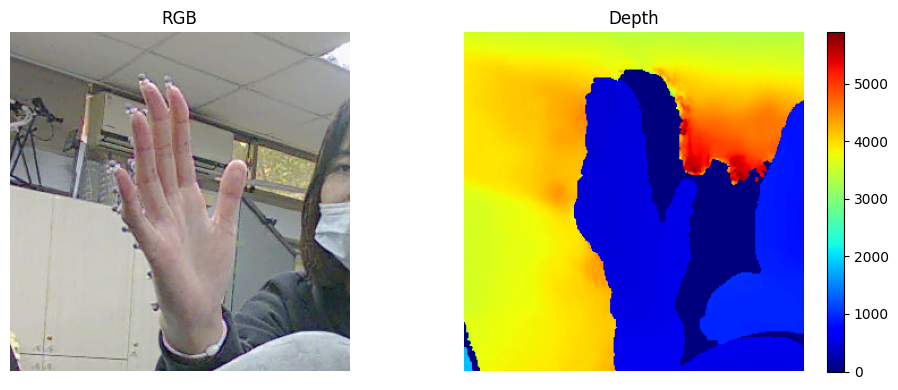

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
recording_rgb = np.load(r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video\rgb\recording_0.npy')
recording_depth = np.load(r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video\depth\recording_0.npy')
color_img = recording_rgb[0]
depth_img = recording_depth[0]

# Rearrange RGB if channels-first
if color_img.ndim == 3 and color_img.shape[0] in (1, 3, 4):
    rgb_image = rearrange(color_img, 'c h w -> h w c')

# Plot RGB - fix indexing error (axes has shape (2,) not (2,2))
ax_rgb = axes[0]  # First subplot
ax_rgb.imshow(rgb_image)
ax_rgb.set_title("RGB")  # Removed undefined cls variable
ax_rgb.axis('off')

# Plot depth - fix indexing error
ax_depth = axes[1]  # Second subplot
ax_depth.imshow(depth_img, cmap='jet')
ax_depth.set_title("Depth")  # Removed undefined cls variable
ax_depth.axis('off')

# Add color bar
cbar = plt.colorbar(ax_depth.imshow(depth_img, cmap='jet'), ax=ax_depth, orientation='vertical')

plt.tight_layout()
plt.show()

#### Extract `X` and `Y` Coordinates

In [202]:
import mmcv
import einops
from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.utils import adapt_mmdet_pipeline
from mmdet.apis import inference_detector, init_detector
from mmpose.structures import merge_data_samples

base_dir = r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook'
os.chdir(base_dir)

det_config = 'configs/rtmdet_nano_320-8xb32_hand.py'
det_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth'
pose_config = 'configs/rtmpose-m_8xb256-210e_hand5-256x256.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth'
device='cuda:0' 

# Build detector
detector = init_detector(det_config, det_checkpoint, device=device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

# Build pose estimator
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    device=device)

img = rgb_image
det_cat_id=0
bbox_thr=0.3
nms_thr=0.3

# Convert image to numpy array if it's a path
if isinstance(img, str):
    img = mmcv.imread(img, channel_order='rgb')
elif isinstance(img, np.ndarray) and img.shape[-1] == 3:
    # Convert BGR to RGB if necessary
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    img = mmcv.bgr2rgb(img)

# Detect hands (bounding boxes)
det_result = inference_detector(detector, img)
pred_instance = det_result.pred_instances.cpu().numpy()

# Extract bounding boxes with scores
bboxes = np.concatenate(
    (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)

# Filter bboxes by category and score
bboxes = bboxes[np.logical_and(pred_instance.labels == det_cat_id,
                                pred_instance.scores > bbox_thr)]

# Apply NMS
bboxes = bboxes[nms(bboxes, nms_thr), :4]

# Detect landmarks for each hand
pose_results = inference_topdown(pose_estimator, img, bboxes)
data_samples = merge_data_samples(pose_results)

# Extract results
hand_detections = bboxes  # Hand bounding boxes
hand_landmarks = data_samples.get('pred_instances', None)  # Hand landmarks

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth


d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\pyorbbec-sdk-experiments\venv\lib\site-packages\mmdet\apis\inference.py:108: UserWarning: palette does not exist, random is used by default. You can also set the palette to customize.
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\pyorbbec-sdk-experiments\venv\lib\site-packages\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\pyorbbec-sdk-experiments\venv\lib\site-packages\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


#### Visualize Hand Landmarks Predictions

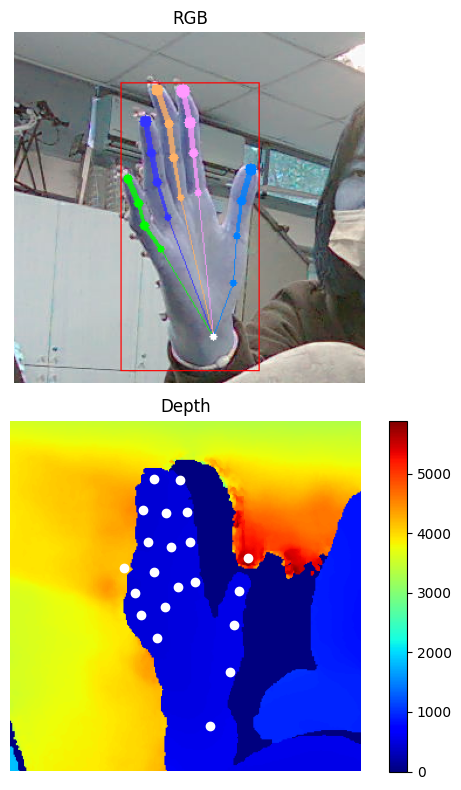

In [235]:
import matplotlib.pyplot as plt

img_vis = visualize_hand_landmarks_cv2(
    img, 
    hand_landmarks, 
    bboxes=hand_detections,
    line_width_multiplier=5.0,
    point_size_multiplier=1.5,
    line_alpha=0.8,
    show_labels=False
)

# Create 2 subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot RGB image
ax_rgb = axes[0]
ax_rgb.imshow(img_vis)
ax_rgb.set_title("RGB")
ax_rgb.axis('off')

# Plot depth image
ax_depth = axes[1]
im = ax_depth.imshow(depth_img, cmap='jet')
ax_depth.set_title("Depth")
ax_depth.axis('off')

def realign_keypoint(keypoint, working_image_size=300, model_input_size=256):
    """
    Scale a (x,y) from model’s 256×256 space back into your 300×300 working image.
    """
    scale = working_image_size / model_input_size
    x_model, y_model = keypoint
    return x_model * scale, y_model * scale

# --- NEW: plot a white dot for each keypoint ---
# assuming hand_landmarks['keypoints'] is an iterable of (x, y) pairs
for kp in hand_landmarks['keypoints'][0]:
    x_model, y_model = kp            # e.g. [170.90657, 260.43405]
    x_real, y_real = realign_keypoint((x_model, y_model), working_image_size=300, model_input_size=256)
    ax_depth.plot(x_model, y_model, marker='o', markersize=6, color='white')

# Add colorbar for depth
cbar = plt.colorbar(im, ax=ax_depth, orientation='vertical')

plt.tight_layout()
plt.show()


In [249]:
print(hand_landmarks['keypoints'][0])
depth_img[117, 202]

[[170.90657  260.43405 ]
 [187.6688   214.33794 ]
 [190.66205  174.22833 ]
 [194.8526   144.89445 ]
 [202.63507  117.356514]
 [157.73625  137.11198 ]
 [153.5457   103.58754 ]
 [150.55244   77.2469  ]
 [144.56593   50.30762 ]
 [142.76999  141.9012  ]
 [136.78348  107.7781  ]
 [132.59293   78.44421 ]
 [122.415855  49.110317]
 [131.99426  158.66342 ]
 [122.415855 128.73088 ]
 [117.62665  103.58754 ]
 [112.83744   76.04961 ]
 [125.40911  185.00406 ]
 [111.640144 165.84723 ]
 [106.25228  146.6904  ]
 [ 97.27252  125.737625]]


5511.0

#### Process Depth Information

- Camera Parameters

```bash
<OBCameraParam depth_intrinsic < fx=610.737fy = 610.737 cx =634.835 cy=398.769 width=1280 height=800 > 
 depth_distortion < k1=0 k2=0 k3=0 k4=0 k5=0 k6=0 p1=0 p2=0 > 
 rgb_intrinsic < fx=610.812fy = 610.846 cx =630.105 cy=394.317 width=1280 height=800 > 
 rgb_distortion < k1=-1.21742 k2=0.758779 k3=-0.162853 k4=-1.19964 k5=0.734512 k6=-0.153537 p1=-1.81318e-05 p2=0.000193372 > 
 transform < rot=[0.999994, 0.0030047, -0.00171156, -0.00300287, 0.999995, 0.00107156, 0.00171477, -0.00106641, 0.999998]
 transform=[-25.0396, 0.0795043, 0.0830964]
```

Image dimensions: 300×300
Scaled camera intrinsics:
fx = 143.159, fy = 229.067, cx = 147.681, cy = 147.869
Keypoint 0: (u, v) = (170, 260)
Keypoint 1: (u, v) = (187, 214)
Keypoint 2: (u, v) = (190, 174)
Keypoint 3: (u, v) = (194, 144)
Keypoint 4: (u, v) = (202, 117)
Keypoint 5: (u, v) = (157, 137)
Keypoint 6: (u, v) = (153, 103)
Keypoint 7: (u, v) = (150, 77)
Keypoint 8: (u, v) = (144, 50)
Keypoint 9: (u, v) = (142, 141)
Keypoint 10: (u, v) = (136, 107)
Keypoint 11: (u, v) = (132, 78)
Keypoint 12: (u, v) = (122, 49)
Keypoint 13: (u, v) = (131, 158)
Keypoint 14: (u, v) = (122, 128)
Keypoint 15: (u, v) = (117, 103)
Keypoint 16: (u, v) = (112, 76)
Keypoint 17: (u, v) = (125, 185)
Keypoint 18: (u, v) = (111, 165)
Keypoint 19: (u, v) = (106, 146)
Keypoint 20: (u, v) = (97, 125)
Keypoint 0: (X, Y, Z) = (0.090, 0.272, 0.553)
Keypoint 1: (X, Y, Z) = (0.151, 0.157, 0.542)
Keypoint 2: (X, Y, Z) = (0.164, 0.063, 0.546)
Keypoint 3: (X, Y, Z) = (0.179, -0.007, 0.543)
Keypoint 4: (X, Y, Z) = (NaN, N

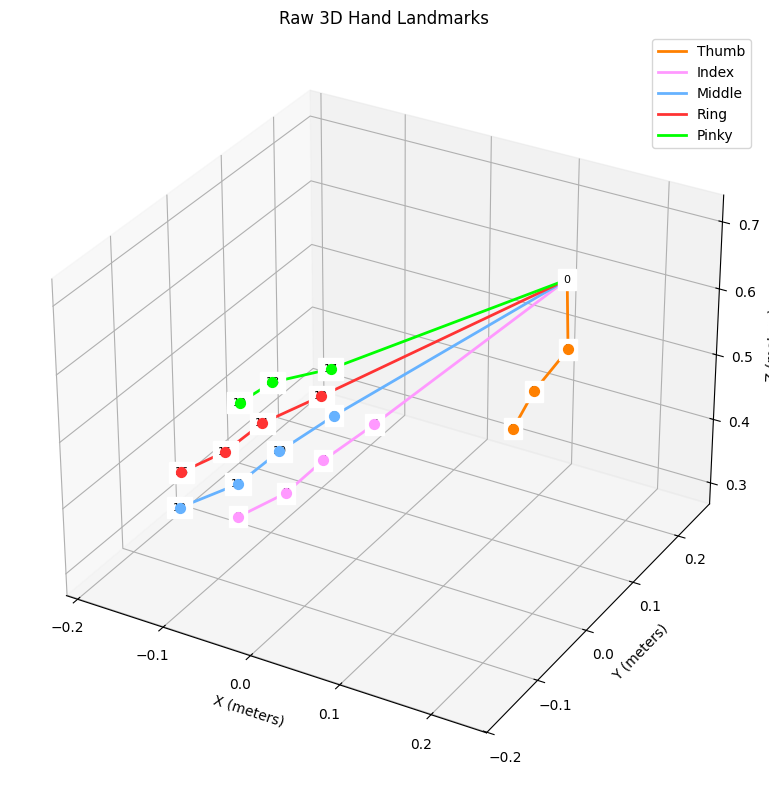

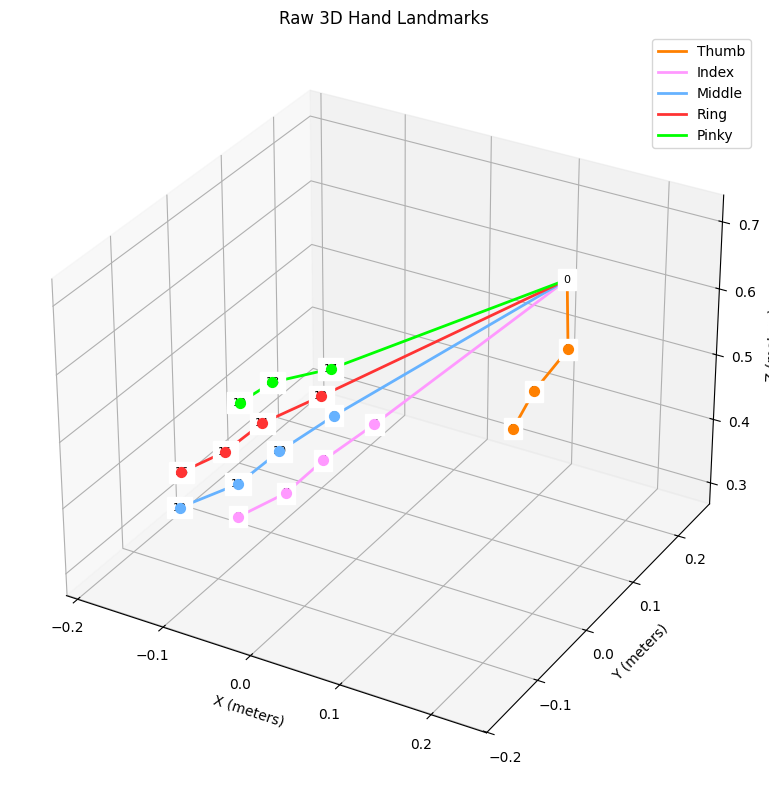

In [245]:
def convert_hand_landmarks_to_3d(hand_landmarks, depth_image, camera_params, 
                                use_window_sampling=False, window_size=5,
                                min_depth=0.001, max_depth=2.0):
    """
    Convert 2D hand landmarks to 3D coordinates using depth data with improved depth validation.
    
    Args:
        hand_landmarks: Detected hand landmarks (keypoints)
        depth_image: Depth image as numpy array
        camera_params: Dictionary containing camera parameters (fx, fy, cx, cy)
        use_window_sampling: If True, use a window around each point for more robust depth
        window_size: Size of the window for depth sampling (if use_window_sampling is True)
        min_depth: Minimum valid depth value in meters (defaults to 0.001m or 1mm)
        max_depth: Maximum valid depth value in meters (defaults to 2.0m)
        
    Returns:
        keypoints_3d: numpy array of shape (21, 3) containing 3D coordinates
    """
    # Extract camera parameters
    fx = camera_params['fx']
    fy = camera_params['fy']
    cx = camera_params['cx']
    cy = camera_params['cy']
    
    # Get current image dimensions
    depth_height, depth_width = depth_image.shape
    
    # Original camera resolution
    original_width = 1280
    original_height = 800
    
    # Scale factor for width and height based on depth image dimensions
    scale_x = depth_width / original_width
    scale_y = depth_height / original_height
    
    # Scale the intrinsic parameters for the current image size
    new_fx = fx * scale_x
    new_fy = fy * scale_y
    new_cx = cx * scale_x
    new_cy = cy * scale_y
    
    print(f"Image dimensions: {depth_width}×{depth_height}")
    print(f"Scaled camera intrinsics:")
    print(f"fx = {new_fx:.3f}, fy = {new_fy:.3f}, cx = {new_cx:.3f}, cy = {new_cy:.3f}")
    
    # Create array for 3D keypoints
    keypoints_3d = np.zeros((21, 3))
    
    # Extract keypoints
    if isinstance(hand_landmarks, dict):
        keypoints = hand_landmarks['keypoints'][0]
    else:
        keypoints = hand_landmarks.keypoints[0]
    
    # Function for robust depth sampling
    def get_robust_depth(depth_img, u, v, window_size=5):
        """Get depth by averaging valid values in a small window around the point"""
        half_size = window_size // 2
        x_start = max(0, int(u) - half_size)
        y_start = max(0, int(v) - half_size)
        x_end = min(depth_img.shape[1], x_start + window_size)
        y_end = min(depth_img.shape[0], y_start + window_size)
        
        window = depth_img[y_start:y_end, x_start:x_end]
        valid_depths = window[(window > 0) & (window < 10000)]  # Filter out invalid values
        
        if len(valid_depths) > 0:
            return np.median(valid_depths)
        else:
            return 0  # No valid depths found
    
    # Calculate 3D coordinates with proper depth validation
    for i, (u, v) in enumerate(keypoints):
        print(f"Keypoint {i}: (u, v) = ({int(u)}, {int(v)})")
        
        # Ensure coordinates are within depth image bounds
        u_valid = max(0, min(int(u), depth_image.shape[1] - 1))
        v_valid = max(0, min(int(v), depth_image.shape[0] - 1))
        
        # Get depth at the keypoint location (in meters)
        if use_window_sampling:
            Z = get_robust_depth(depth_image, u_valid, v_valid, window_size) / 1000.0
        else:
            Z = depth_image[v_valid, u_valid] / 1000.0  # Assuming depth is in mm, convert to meters
        
        # Validate depth value - set to NaN if invalid
        if Z < min_depth or Z > max_depth:
            X, Y, Z = float('nan'), float('nan'), float('nan')
        else:
            # Use the camera model to unproject the pixel to 3D using floating-point coordinates
            X = (u - new_cx) * Z / new_fx
            Y = (v - new_cy) * Z / new_fy
        
        keypoints_3d[i] = [X, Y, Z]
    
    # Print results
    for i in range(len(keypoints_3d)):
        X, Y, Z = keypoints_3d[i]
        if np.isnan(Z):
            print(f"Keypoint {i}: (X, Y, Z) = (NaN, NaN, NaN) [Invalid depth]")
        else:
            print(f"Keypoint {i}: (X, Y, Z) = ({X:.3f}, {Y:.3f}, {Z:.3f})")
    
    return keypoints_3d

def get_robust_depth(depth_img, u, v, window_size=5):
    """
    Get depth by averaging valid values in a small window around the point
    
    Args:
        depth_img: Depth image
        u, v: Pixel coordinates
        window_size: Size of the window (e.g., 5 for a 5x5 window)
        
    Returns:
        Robust depth value or 0 if no valid depths found
    """
    half_size = window_size // 2
    x_start = max(0, u - half_size)
    y_start = max(0, v - half_size)
    x_end = min(depth_img.shape[1], x_start + window_size)
    y_end = min(depth_img.shape[0], y_start + window_size)
    
    window = depth_img[y_start:y_end, x_start:x_end]
    valid_depths = window[(window > 0) & (window < 10000)]  # Filter out invalid values
    
    if len(valid_depths) > 0:
        return np.median(valid_depths)
    else:
        return 0  # No valid depths found

def visualize_hand_3d(keypoints_3d, title="3D Hand Landmarks", figsize=(10, 8),
                     show_labels=True, line_width=2, marker_size=50, view_angle=None):
    """
    Visualize 3D hand landmarks using skeleton structure from OneHand10K dataset
    
    Args:
        keypoints_3d: numpy array of shape (21, 3) containing 3D coordinates
        title: Plot title
        figsize: Figure size as tuple (width, height)
        show_labels: Whether to show keypoint indices
        line_width: Width of skeleton lines
        marker_size: Size of keypoint markers
        view_angle: Optional tuple (elevation, azimuth) to set view angle
        
    Returns:
        fig: The matplotlib figure object
    """
    # Skip if all points are NaN
    if np.isnan(keypoints_3d).all():
        print("No valid points to visualize")
        return None
    
    # Define keypoint names mapping
    keypoint_names = {
        0: 'wrist',
        1: 'thumb1', 2: 'thumb2', 3: 'thumb3', 4: 'thumb4',
        5: 'forefinger1', 6: 'forefinger2', 7: 'forefinger3', 8: 'forefinger4',
        9: 'middle_finger1', 10: 'middle_finger2', 11: 'middle_finger3', 12: 'middle_finger4',
        13: 'ring_finger1', 14: 'ring_finger2', 15: 'ring_finger3', 16: 'ring_finger4',
        17: 'pinky_finger1', 18: 'pinky_finger2', 19: 'pinky_finger3', 20: 'pinky_finger4'
    }
    
    # Define colors for each finger from OneHand10K dataset
    keypoint_colors = {
        'wrist': '#FFFFFF',           # White
        'thumb': '#FF8000',           # Orange
        'forefinger': '#FF99FF',      # Pink
        'middle_finger': '#66B2FF',   # Light Blue
        'ring_finger': '#FF3333',     # Red
        'pinky_finger': '#00FF00'     # Green
    }
    
    # Define connections based on OneHand10K dataset's skeleton_info
    connections = [
        # Thumb connections
        ('wrist', 'thumb1', keypoint_colors['thumb']),
        ('thumb1', 'thumb2', keypoint_colors['thumb']),
        ('thumb2', 'thumb3', keypoint_colors['thumb']),
        ('thumb3', 'thumb4', keypoint_colors['thumb']),
        
        # Index finger connections
        ('wrist', 'forefinger1', keypoint_colors['forefinger']),
        ('forefinger1', 'forefinger2', keypoint_colors['forefinger']),
        ('forefinger2', 'forefinger3', keypoint_colors['forefinger']),
        ('forefinger3', 'forefinger4', keypoint_colors['forefinger']),
        
        # Middle finger connections
        ('wrist', 'middle_finger1', keypoint_colors['middle_finger']),
        ('middle_finger1', 'middle_finger2', keypoint_colors['middle_finger']),
        ('middle_finger2', 'middle_finger3', keypoint_colors['middle_finger']),
        ('middle_finger3', 'middle_finger4', keypoint_colors['middle_finger']),
        
        # Ring finger connections
        ('wrist', 'ring_finger1', keypoint_colors['ring_finger']),
        ('ring_finger1', 'ring_finger2', keypoint_colors['ring_finger']),
        ('ring_finger2', 'ring_finger3', keypoint_colors['ring_finger']),
        ('ring_finger3', 'ring_finger4', keypoint_colors['ring_finger']),
        
        # Pinky finger connections
        ('wrist', 'pinky_finger1', keypoint_colors['pinky_finger']),
        ('pinky_finger1', 'pinky_finger2', keypoint_colors['pinky_finger']),
        ('pinky_finger2', 'pinky_finger3', keypoint_colors['pinky_finger']),
        ('pinky_finger3', 'pinky_finger4', keypoint_colors['pinky_finger'])
    ]
    
    # Convert string connections to index connections
    index_connections = []
    for start_name, end_name, color in connections:
        # Get indices for the start and end points
        start_idx = [idx for idx, name in keypoint_names.items() if name == start_name][0]
        end_idx = [idx for idx, name in keypoint_names.items() if name == end_name][0]
        index_connections.append((start_idx, end_idx, color))
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot keypoints
    for i, (x, y, z) in enumerate(keypoints_3d):
        if not np.isnan(x) and not np.isnan(y) and not np.isnan(z):
            # Determine color based on keypoint type
            if 'thumb' in keypoint_names[i]:
                color = keypoint_colors['thumb']
            elif 'forefinger' in keypoint_names[i]:
                color = keypoint_colors['forefinger']
            elif 'middle_finger' in keypoint_names[i]:
                color = keypoint_colors['middle_finger']
            elif 'ring_finger' in keypoint_names[i]:
                color = keypoint_colors['ring_finger']
            elif 'pinky_finger' in keypoint_names[i]:
                color = keypoint_colors['pinky_finger']
            else:  # wrist
                color = keypoint_colors['wrist']
            
            # Plot the keypoint
            ax.scatter(x, y, z, c=color, marker='o', s=marker_size)
            
            # Add keypoint label
            if show_labels:
                ax.text(x, y, z, str(i), color='black', fontsize=8, 
                        backgroundcolor='white', ha='center', va='center')
    
    # Plot connections
    for start_idx, end_idx, color in index_connections:
        start_point = keypoints_3d[start_idx]
        end_point = keypoints_3d[end_idx]
        
        # Only draw connection if both points are valid
        if not (np.isnan(start_point).any() or np.isnan(end_point).any()):
            ax.plot([start_point[0], end_point[0]],
                   [start_point[1], end_point[1]],
                   [start_point[2], end_point[2]], 
                   color=color, linewidth=line_width)
    
    # Set labels and title
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_zlabel('Z (meters)')
    ax.set_title(title)
    
    # Make the plot more accurate by setting equal aspect ratio
    max_range = np.nanmax([
        np.nanmax(keypoints_3d[:, 0]) - np.nanmin(keypoints_3d[:, 0]),
        np.nanmax(keypoints_3d[:, 1]) - np.nanmin(keypoints_3d[:, 1]),
        np.nanmax(keypoints_3d[:, 2]) - np.nanmin(keypoints_3d[:, 2])
    ])
    
    # Get center points of the data
    mid_x = (np.nanmax(keypoints_3d[:, 0]) + np.nanmin(keypoints_3d[:, 0])) * 0.5
    mid_y = (np.nanmax(keypoints_3d[:, 1]) + np.nanmin(keypoints_3d[:, 1])) * 0.5
    mid_z = (np.nanmax(keypoints_3d[:, 2]) + np.nanmin(keypoints_3d[:, 2])) * 0.5
    
    # Set equal scaling
    ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    
    # Set custom view angle if provided
    if view_angle:
        ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Add a legend for each finger
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=keypoint_colors['thumb'], lw=2, label='Thumb'),
        Line2D([0], [0], color=keypoint_colors['forefinger'], lw=2, label='Index'),
        Line2D([0], [0], color=keypoint_colors['middle_finger'], lw=2, label='Middle'),
        Line2D([0], [0], color=keypoint_colors['ring_finger'], lw=2, label='Ring'),
        Line2D([0], [0], color=keypoint_colors['pinky_finger'], lw=2, label='Pinky')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig

# Camera parameters
camera_params = {
    'fx': 610.812,
    'fy': 610.846,
    'cx': 630.105,
    'cy': 394.317
}

# Convert landmarks to 3D
keypoints_3d_raw = convert_hand_landmarks_to_3d(
    hand_landmarks=hand_landmarks,
    depth_image=copy.deepcopy(depth_img),
    camera_params=camera_params,
    use_window_sampling=False
)

# Visualize raw 3D hand
visualize_hand_3d(keypoints_3d_raw, "Raw 3D Hand Landmarks")